In [1]:
# Import multiple essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import STOPWORDS

# ignore the warning message
import warnings
warnings.filterwarnings('ignore')
import os


# 
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score


In [ ]:
# Data Insights:
# Few problems to be solved:
# 1. We wish to understand why 'good' employee wish to leave.
# 2. Predict who is likely to leave

In [ ]:
# Kaggle HR Analytics 
# URL: https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study

In [2]:
# Access files with relative path
path = 'archive/'
employee = pd.read_csv(path + 'employee_survey_data.csv')
general = pd.read_csv(path + 'general_data.csv')
in_time = pd.read_csv(path + 'in_time.csv')
manager_survey = pd.read_csv(path + 'manager_survey_data.csv')
out_time = pd.read_csv(path + 'out_time.csv')


### Data Understanding

In [3]:
employee.head(30)

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0
5,6,3.0,2.0,2.0
6,7,1.0,3.0,1.0
7,8,1.0,2.0,3.0
8,9,2.0,4.0,3.0
9,10,2.0,1.0,3.0


In [50]:
employee.describe()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4410.000000,4385.000000,4390.000000,4372.000000
mean,2205.500000,2.723603,2.728246,2.761436
std,1273.201673,1.092756,1.101253,0.706245
min,1.000000,1.000000,1.000000,1.000000
25%,1103.250000,2.000000,2.000000,2.000000
50%,2205.500000,3.000000,3.000000,3.000000
75%,3307.750000,4.000000,4.000000,3.000000
max,4410.000000,4.000000,4.000000,4.000000


In [4]:
# Acquire basic information about each dataset
def missing_columns(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values.sort_values(ascending = False)
    
    return missing_values

def df_info_(df):
    """
        Information about the DataFrame
    """

    # remove unnecessary columns
    try:
        df.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)
    except:
        print("Column does not exist in the dataframe")
    else:
        print("The code has no problem")

    features_dtypes = df.dtypes
    rows,columns = df.shape

    missing_col = missing_columns(df)
    features_names = missing_col.index.values
    missing_values = missing_col.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                        'Number of Missing Values'.upper(),
                                        'The first few samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_col),3))+' %'), end=" ")

        for i in range(5):
            print(df[features_names].iloc[i], end=",")

        print("="*50)
        

In [5]:
df_info_(employee)

Column does not exist in the dataframe
===> This data frame contains 4410 rows and 4 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
WorkLifeBalance float64        38-45.783 %          2.0,4.0,1.0,3.0,3.0,==================================================
EnvironmentSatisfaction float64        25-30.12 %           3.0,3.0,2.0,4.0,4.0,==================================================
JobSatisfaction float64        20-24.096 %          4.0,2.0,2.0,4.0,1.0,==================================================
EmployeeID      int64          0-0.0 %              1,2,3,4,5,==================================================


In [6]:
df_info_(general)

Column does not exist in the dataframe
===> This data frame contains 4410 rows and 24 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
NumCompaniesWorked float64        19-67.857 %          1.0,0.0,1.0,3.0,4.0,==================================================
TotalWorkingYears float64        9-32.143 %           1.0,6.0,5.0,13.0,9.0,==================================================
Age             int64          0-0.0 %              51,31,32,38,32,==================================================
Attrition       object         0-0.0 %              No,Yes,No,No,No,==================================================
YearsSinceLastPromotion int64          0-0.0 %              0,1,0,7,0,==================================================
YearsAtCompany  int64          0-0.0 %              1,5,5,8,6,==================================================
TrainingTimesLastYear int64          0-0.0 %              6,3,2,5,2,=====================================

In [7]:
df_info_(in_time)

The code has no problem
===> This data frame contains 4410 rows and 261 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
2015-01-01      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-01-14      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-11-11      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-11-10      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-11-09      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-05-01      float64        4410-4.043 %         nan,nan,nan,nan,nan,==================================================
2015-12-25      float64        4410-4.043 %         nan,nan,nan,nan,nan,================================

In [8]:
df_info_(manager_survey)

Column does not exist in the dataframe
===> This data frame contains 4410 rows and 3 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
EmployeeID      int64          0-nan %              1,2,3,4,5,==================================================
JobInvolvement  int64          0-nan %              3,2,3,2,3,==================================================
PerformanceRating int64          0-nan %              3,4,3,3,3,==================================================


/var/folders/c3/z8gl7_754n15kcrx5rz7k0840000gn/T/ipykernel_34690/3514940326.py:41: RuntimeWarning: invalid value encountered in long_scalars
  str(round(100*missing_values/sum(missing_col),3))+' %'), end=" ")


In [9]:
in_time.head(30)

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaN,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,NaN,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,NaN,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,NaN,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,NaN,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09
5,NaN,2015-01-02 09:43:08,2015-01-05 10:14:00,2015-01-06 10:08:42,2015-01-07 10:18:15,2015-01-08 10:33:09,2015-01-09 10:19:13,2015-01-12 09:48:30,2015-01-13 09:54:26,NaN,...,2015-12-18 10:24:55,2015-12-21 09:44:43,2015-12-22 09:38:00,2015-12-23 09:53:27,2015-12-24 09:38:46,NaN,NaN,2015-12-29 09:51:47,2015-12-30 10:20:39,2015-12-31 09:55:25
6,NaN,2015-01-02 10:20:13,2015-01-05 09:30:01,2015-01-06 09:48:47,2015-01-07 09:46:18,2015-01-08 09:59:29,2015-01-09 10:13:26,2015-01-12 09:23:42,2015-01-13 10:00:14,NaN,...,2015-12-18 10:12:15,2015-12-21 09:52:10,NaN,2015-12-23 10:22:03,2015-12-24 10:24:29,NaN,2015-12-28 10:19:47,2015-12-29 09:44:16,2015-12-30 10:05:48,2015-12-31 10:04:10
7,NaN,2015-01-02 09:57:10,2015-01-05 09:48:56,2015-01-06 09:54:04,2015-01-07 09:52:31,2015-01-08 09:58:31,2015-01-09 09:53:12,2015-01-12 09:58:57,2015-01-13 09:42:05,NaN,...,2015-12-18 10:16:27,2015-12-21 10:12:52,2015-12-22 10:58:57,2015-12-23 09:45:12,2015-12-24 09:46:29,NaN,2015-12-28 09:59:24,2015-12-29 09:54:34,2015-12-30 09:43:37,2015-12-31 10:33:00
8,NaN,NaN,2015-01-05 10:01:42,2015-01-06 09:50:56,2015-01-07 10:02:57,2015-01-08 10:07:22,2015-01-09 09:59:54,2015-01-12 10:14:55,NaN,NaN,...,2015-12-18 10:19:42,2015-12-21 10:18:09,2015-12-22 09:39:54,2015-12-23 09:48:05,2015-12-24 10:00:32,NaN,NaN,2015-12-29 10:06:27,2015-12-30 10:17:59,2015-12-31 09:28:41
9,NaN,2015-01-02 09:55:53,2015-01-05 10:21:06,2015-01-06 10:03:01,2015-01-07 10:06:01,2015-01-08 09:52:25,2015-01-09 09:36:12,2015-01-12 09:59:26,2015-01-13 10:08:33,NaN,...,2015-12-18 09:57:20,2015-12-21 09:39:07,2015-12-22 10:17:05,2015-12-23 10:25:33,2015-12-24 10:21:01,NaN,2015-12-28 10:20:31,2015-12-29 10:12:14,2015-12-30 10:08:04,2015-12-31 10:00:21


In [10]:
out_time.head(30)

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14
5,6,NaN,2015-01-02 20:29:54,2015-01-05 20:57:19,2015-01-06 21:06:31,2015-01-07 20:36:10,2015-01-08 21:33:43,2015-01-09 21:25:12,2015-01-12 20:38:47,2015-01-13 20:10:38,...,2015-12-18 20:58:47,2015-12-21 20:48:45,2015-12-22 20:46:45,2015-12-23 20:51:06,2015-12-24 20:06:50,NaN,NaN,2015-12-29 20:45:24,2015-12-30 21:14:29,2015-12-31 20:45:43
6,7,NaN,2015-01-02 17:10:31,2015-01-05 17:02:19,2015-01-06 17:04:47,2015-01-07 16:11:37,2015-01-08 17:01:52,2015-01-09 17:23:17,2015-01-12 16:04:41,2015-01-13 16:55:05,...,2015-12-18 17:39:13,2015-12-21 16:29:19,NaN,2015-12-23 17:19:40,2015-12-24 17:19:19,NaN,2015-12-28 16:52:09,2015-12-29 16:48:00,2015-12-30 17:08:59,2015-12-31 16:56:25
7,8,NaN,2015-01-02 17:02:35,2015-01-05 16:52:09,2015-01-06 16:33:13,2015-01-07 16:42:05,2015-01-08 16:18:14,2015-01-09 16:49:56,2015-01-12 16:41:14,2015-01-13 16:26:12,...,2015-12-18 17:20:14,2015-12-21 17:16:25,2015-12-22 17:37:19,2015-12-23 16:33:44,2015-12-24 16:23:30,NaN,2015-12-28 16:16:24,2015-12-29 17:09:49,2015-12-30 16:20:00,2015-12-31 17:12:02
8,9,NaN,NaN,2015-01-05 17:00:43,2015-01-06 17:10:01,2015-01-07 17:36:23,2015-01-08 17:30:35,2015-01-09 17:19:58,2015-01-12 17:14:54,NaN,...,2015-12-18 16:54:59,2015-12-21 17:29:59,2015-12-22 16:58:51,2015-12-23 17:10:38,2015-12-24 16:47:09,NaN,NaN,2015-12-29 17:12:18,2015-12-30 17:24:51,2015-12-31 16:32:40
9,10,NaN,2015-01-02 17:17:31,2015-01-05 17:27:11,2015-01-06 17:33:55,2015-01-07 17:15:12,2015-01-08 16:42:03,2015-01-09 16:37:48,2015-01-12 17:54:23,2015-01-13 17:21:32,...,2015-12-18 17:20:04,2015-12-21 16:46:26,2015-12-22 17:38:33,2015-12-23 17:14:07,2015-12-24 17:40:42,NaN,2015-12-28 17:18:11,2015-12-29 16:52:08,2015-12-30 17:23:21,2015-12-31 17:03:09


In [11]:
general.head(30)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,3.0,Y,13,8,0,28.0,5,7,7,7
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,2.0,Y,20,8,1,5.0,2,0,0,0
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,2.0,Y,22,8,3,10.0,2,0,0,0
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,0.0,Y,21,8,0,10.0,2,9,7,8
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,1.0,Y,13,8,1,6.0,2,6,1,5


In [12]:
manager_survey.head(30)

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3
5,6,3,3
6,7,3,4
7,8,3,4
8,9,3,4
9,10,3,3


In [14]:
general['Department'].isnull().any()

False

### Data Visualisation

In [15]:
def words_popular(df,col,heads):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color = 'white', stopwords = stopwords).generate(str(df[col]))
    
    plt.rcParams['figure.figsize'] = (12, 8)
    print(wordcloud)
    plt.imshow(wordcloud)
    plt.title(heads, fontsize = 30)
    plt.axis('off')
    plt.show()

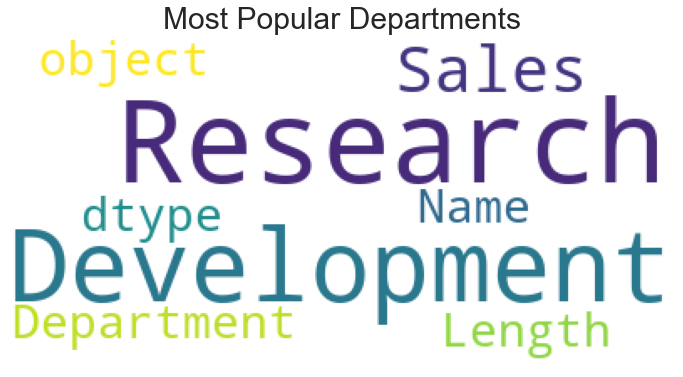

In [16]:
# Department Analysis
# Looking at the most popular departments
words_popular(general,'Department','Most Popular Departments')


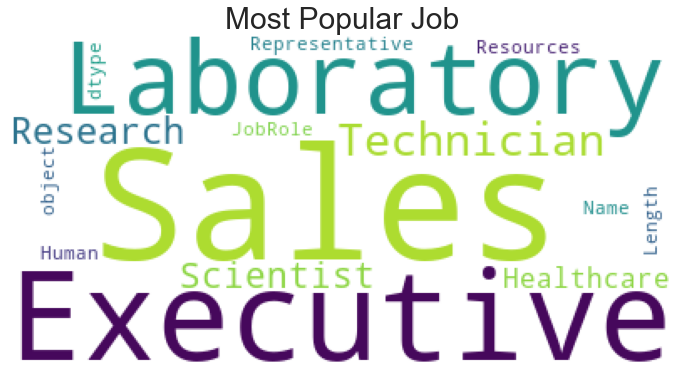

In [17]:
# Job Role Analysis
words_popular(general,'JobRole','Most Popular Job')


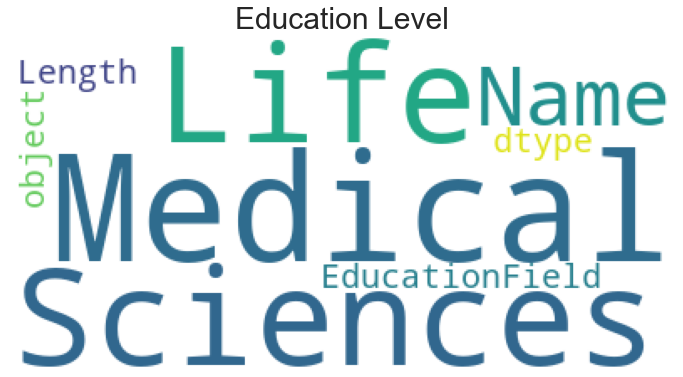

In [33]:
words_popular(general,'EducationField','Education Level')

In [19]:
# Performance rating distribution
ratings = manager_survey['PerformanceRating'].unique()
print(ratings)

[3 4]


In [34]:
general.head(30)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,3.0,Y,13,8,0,28.0,5,7,7,7
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,2.0,Y,20,8,1,5.0,2,0,0,0
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,2.0,Y,22,8,3,10.0,2,0,0,0
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,0.0,Y,21,8,0,10.0,2,9,7,8
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,1.0,Y,13,8,1,6.0,2,6,1,5


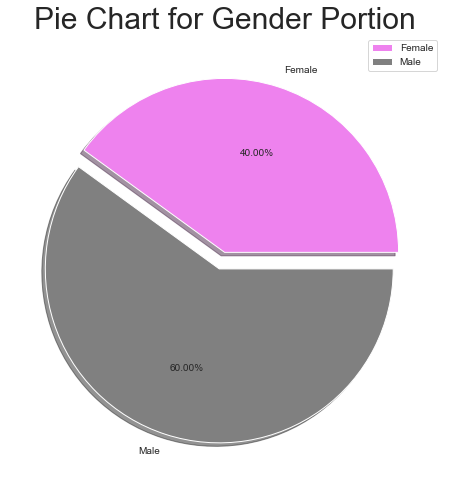

In [28]:
# A Pie chart representing the portion of gender 
counts = general.groupby(['Gender'])['EmployeeID'].count()
female_count = counts.loc["Female",]
male_count = counts.loc['Male',]

# Plotting pie chart
size = [female_count,male_count]
labels = ['Female','Male']
colors = ['violet','grey']
explode = [0,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('Pie Chart for Gender Portion', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()


/Users/jamesli/.conda/envs/untitled/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


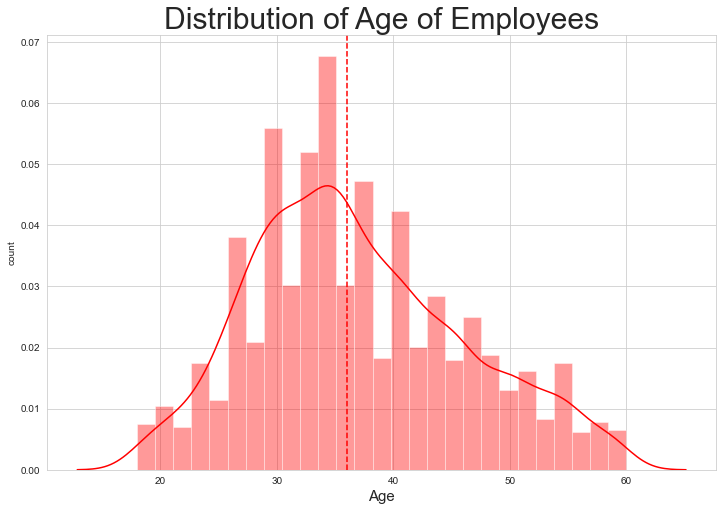

In [51]:
# Distribution of Age of Employees
sns.distplot(general['Age'], color = 'red')
plt.title('Distribution of Age of Employees', fontsize = 30)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('count')
plt.axvline(np.median(general['Age']), 0, linestyle='--', linewidth=1.5, color='r')
plt.show()

/Users/jamesli/.conda/envs/untitled/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


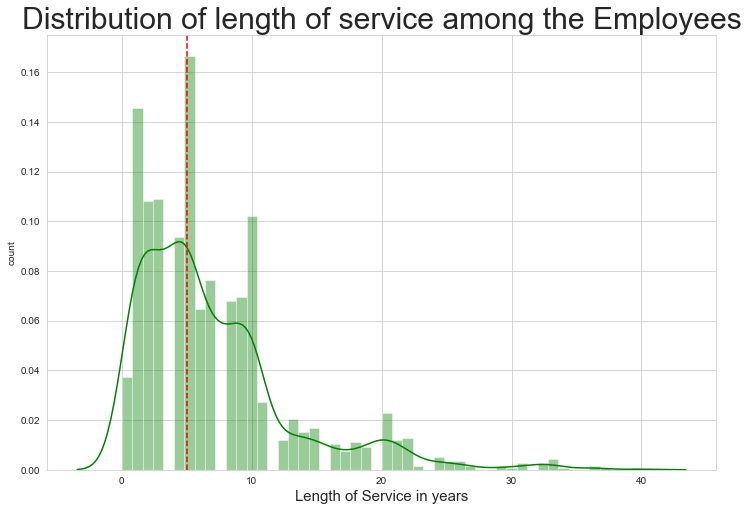

In [52]:
# checking the distribution of length of service
sns.distplot(general['YearsAtCompany'], color = 'green')
plt.title('Distribution of length of service among the Employees', fontsize = 30)
plt.xlabel('Length of Service in years', fontsize = 15)
plt.ylabel('count')
plt.axvline(np.median(general['YearsAtCompany']), 0, linestyle='--', linewidth=1.5, color='r')
plt.show()

In [53]:
general['BusinessTravel'].unique()

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

In [ ]:
# box plot to see distancefromhome affect 
general.boxplot(column='satisfaction_level', by='left')
plt.show()

In [30]:
general.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [31]:
general['Over18'].unique()

array(['Y'], dtype=object)

In [35]:
employee.head(30)

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0
5,6,3.0,2.0,2.0
6,7,1.0,3.0,1.0
7,8,1.0,2.0,3.0
8,9,2.0,4.0,3.0
9,10,2.0,1.0,3.0


In [48]:
employee.isnull().any()
# Remove all isnull rows
employee_clean = employee.copy(deep = True)
employee_clean = employee_clean.dropna()

print(employee_clean.shape)
print('-'*50)
print(employee.shape)

(4327, 4)
--------------------------------------------------
(4410, 4)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


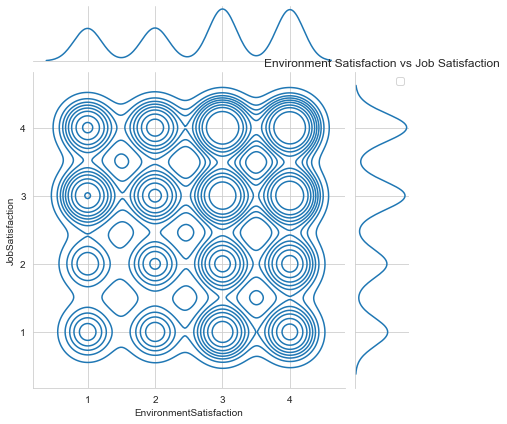

In [42]:
sns.jointplot(x="EnvironmentSatisfaction", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Environment Satisfaction')
plt.ylabel('Job Satisfaction')
plt.title('Environment Satisfaction vs Job Satisfaction')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


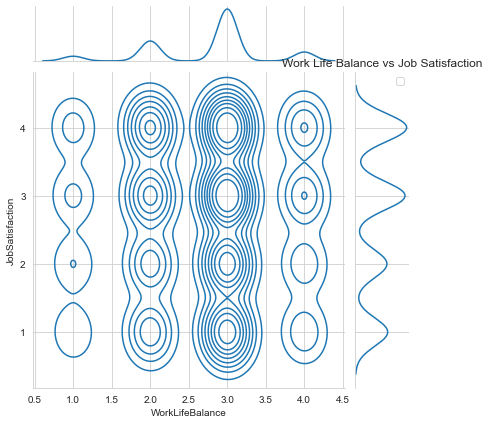

In [43]:
sns.jointplot(x="WorkLifeBalance", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Work Life Balance')
plt.ylabel('Job Satisfaction')
plt.title('Work Life Balance vs Job Satisfaction')

plt.legend()
plt.show()

/var/folders/c3/z8gl7_754n15kcrx5rz7k0840000gn/T/ipykernel_34690/1808096023.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


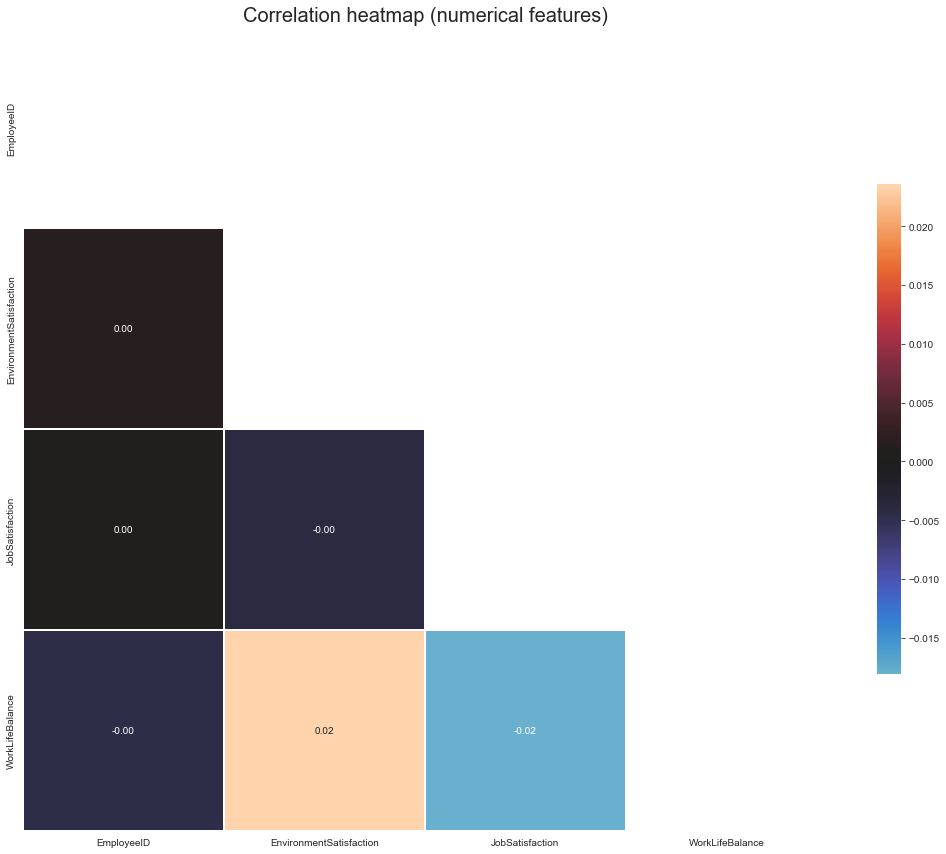

In [49]:
# Generate heatmap about employee table
f,ax = plt.subplots(figsize=(18, 18))
corr = employee_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, linewidths=.1, fmt= '.2f',ax=ax,
            center=0, square=True, cbar_kws={'shrink': .5}
            )
plt.title('Correlation heatmap (numerical features)', size=20)
plt.show();

Data Pre-processing

In [ ]:
# Drop Over18 column in general df
general['Over18'].unique()


In [ ]:
# filling missing values



Oversampling of the Model

In [ ]:

from imblearn.over_sampling import SMOTE

x_sample, y_sample = SMOTE().fit_sample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

In [ ]:

# splitting x and y into train and validation sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_sample, y_sample, test_size = 0.2, random_state = 0)

print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_valid.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_valid.shape)

In [ ]:
# standard scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

Applying PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = None)
x_train = pca.fit_transform(general)
x_test = pca.transform(general)
x_valid = pca.transform(general)

Xgboost Algorithm

In [ ]:
# 
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score